In [95]:
import os
import cv2
import numpy as np
from typing import Tuple, Dict, Union
from extensions import IMAGE_EXTENSIONS

In [96]:
def read_bal_data(
    image_dir: str,
    pattern_size: Tuple[int, int] = (10, 7),
    result_dir: str = None,
    ) -> Dict[str, Union[float, int]]:
    
    if result_dir is not None and not os.path.exists(result_dir):
        os.makedirs(result_dir, exist_ok=True)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)

    objpoints = []
    imgpoints = []
    calibrated_cnt = 0
    h, w = None, None

    for file in os.listdir(image_dir):
        ex = file.split('.')[-1]
        if ex not in IMAGE_EXTENSIONS:
            continue
        print(f'\rProcessing: {calibrated_cnt}', end='')

        img_path = os.path.join(image_dir, file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        if h is None or w is None:
            h, w = img.shape[:2]

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # チェスボードからコーナーを検出
        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
        
        if not ret:
            continue

        objpoints.append(objp)
        corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners)

        if result_dir is not None:
            cv2.drawChessboardCorners(img, pattern_size, corners, ret)
            save_path = os.path.join(result_dir, f'calib_{file}.jpg')
            cv2.imwrite(save_path, img)
        calibrated_cnt += 1

    if len(objpoints) == 0 or len(imgpoints) == 0:
        raise ValueError('No calibration data found')

    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w, h), None, None)
    
    return np.array(camera_matrix), np.array(dist_coeffs), np.array(rvecs), np.array(tvecs), np.array(objpoints[0]), np.array(imgpoints)

In [97]:
image_dir = "img"
camera_matrix, distortion_coefficients, rotation_vectors, translation_vectors, points_3d, points_2d  = read_bal_data(image_dir, result_dir='data/calib_result')

Processing: 32

In [98]:
# 焦点距離の取得（焦点距離はx方向とy方向が同じと仮定）
focal_length_x = camera_matrix[0, 0]
focal_length_y = camera_matrix[1, 1]
focal_length = (focal_length_x + focal_length_y) / 2

#2つの歪み係数の取得
distortion_coefficients = distortion_coefficients[0, :2]

In [99]:
# カメラパラメータ配列の初期化
cam = np.zeros((len(rotation_vectors), 3, 3))

# 各カメラのパラメータを配列に格納
for i in range(len(rotation_vectors)):
    cam[i, 0, :3] = rotation_vectors[i]  # 回転行列の最初の行
    cam[i, 1, :3] = translation_vectors[i]  # 並行移動ベクトル
    cam[i, 2, 0] = focal_length  # 焦点距離
    cam[i, 2, 1:3] = distortion_coefficients  # 歪みパラメータ

ValueError: could not broadcast input array from shape (3,1) into shape (3,)

In [ ]:
# reshape
camera_params = cam.reshape(len(rotation_vectors), 9)
camera_indices = np.repeat(np.arange(33),70)
point_indices = np.repeat(np.arange(33),70)
points_2d = points_2d.reshape(2310, 2)

In [ ]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

n_cameras: 33
n_points: 70
Total number of parameters: 507
Total number of residuals: 4620


In [ ]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

In [ ]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""

    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(points_proj**2, axis=1)
    r = 1 + k1 * n + k2 * n**2
    points_proj *= (r * f)[:, np.newaxis]
    return points_proj

In [ ]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))    
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

In [ ]:
from scipy.sparse import lil_matrix

def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 9 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1

    return A

(507,)


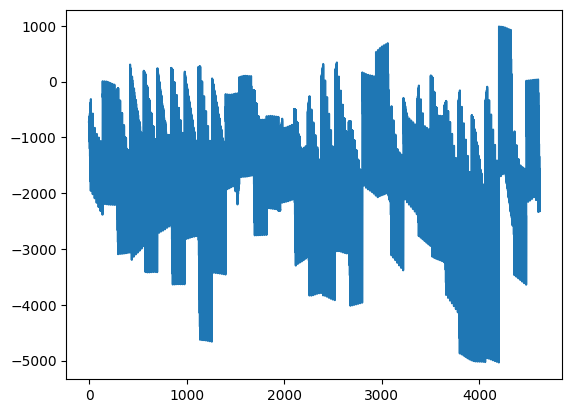

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)
plt.plot(f0)

In [ ]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

In [ ]:
import time
from scipy.optimize import least_squares

t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.0799e+09                                    2.32e+08    
       1              4         6.9354e+09      1.14e+09       1.30e+04       2.91e+08    
       2              5         5.1340e+09      1.80e+09       4.99e+03       4.28e+08    
       3              6         4.4370e+09      6.97e+08       2.19e+04       8.63e+09    
       4              7         2.4820e+09      1.96e+09       1.95e+03       2.50e+09    
       5              9         1.9148e+09      5.67e+08       1.86e+03       1.48e+09    
       6             10         1.2951e+09      6.20e+08       5.16e+03       4.80e+08    
       7             11         9.6518e+08      3.30e+08       8.54e+02       3.64e+08    
       8             12         7.6553e+08      2.00e+08       2.90e+03       3.91e+07    
       9             13         7.3662e+08      2.89e+07       6.53e+02       1.27e+07    

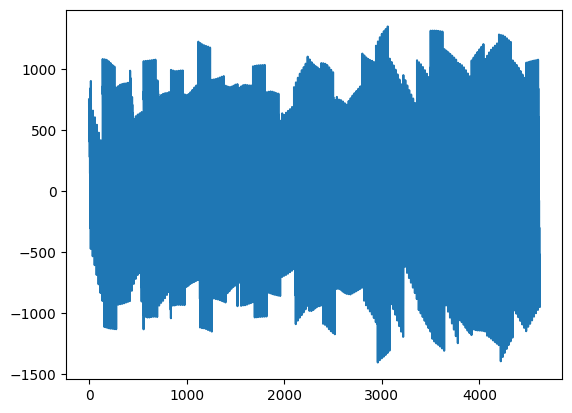

In [ ]:
plt.plot(res.fun)

In [ ]:
res.x[:33*9].reshape(33, 9)[0]

array([ 2.72764384e-01, -8.93669170e-01, -1.14712106e+00, -5.25133482e+00,
       -2.39320222e+00,  3.15948264e+01,  8.80652510e+03,  6.88741868e+00,
        3.03635847e+02])